In [1]:
from __future__ import print_function
from generate_data import simulate_data
import pandas as pd
from shifted_beta_survival import ShiftedBetaSurvival

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Getting Simulated Data

In [2]:
data = simulate_data(50000)
train, test, params = data['train'], data['test'], data['params']

In [3]:
train.head()

,id,category,counts,numerical,alpha_true,beta_true,age,alive
0,0,cat_b,0,1.486918,1.344507,1.574800,1,0
1,1,cat_b,1,1.111382,1.231800,1.366600,10,1
2,2,cat_a,0,0.570045,1.598971,2.125136,1,0
3,3,cat_a,0,0.996263,1.830555,2.152101,1,0
4,4,cat_a,0,1.193894,1.901688,2.149457,4,0


In [4]:
train.groupby('category').mean().drop('id', axis=1)

,counts,numerical,alpha_true,beta_true,age,alive
category,,,,,,
cat_a,0.255798,1.001347,1.854426,2.087699,2.750000,0.064034
cat_b,0.257501,0.999257,1.164272,1.511384,3.223130,0.113636
cat_c,0.239443,1.013674,1.669724,4.702833,4.373081,0.184021


In [5]:
train.groupby('counts').mean().drop('id', axis=1)

,numerical,alpha_true,beta_true,age,alive
counts,,,,,
0,1.003021,1.551465,2.406510,3.284314,0.108411
1,1.000961,1.649296,2.047841,2.918717,0.082090
2,0.997661,1.768826,1.774981,2.478477,0.057947
3,1.074961,1.971068,1.420142,2.160714,0.017857
4,1.144350,1.505985,0.867915,1.000000,0.000000


In [6]:
train[['numerical', 'alpha_true', 'beta_true', 'age', 'alive']].corr()

,numerical,alpha_true,beta_true,age,alive
numerical,1.000000,0.580256,0.031246,-0.098951,-0.085040
alpha_true,0.580256,1.000000,0.276225,-0.104831,-0.098576
beta_true,0.031246,0.276225,1.000000,0.162600,0.103710
age,-0.098951,-0.104831,0.162600,1.000000,0.779739
alive,-0.085040,-0.098576,0.103710,0.779739,1.000000


 # Creating and Training the Model

In [7]:
# START MODELING
# Create the sbs object using all features. Lets keep gamma small and let
# the model "overfit" if necessary. We have enough data.
feature_list = ['category', 'counts', 'numerical']

# something
sbs = ShiftedBetaSurvival(age='age',
                          alive='alive',
                          features=feature_list,
                          gamma=1e-3,
                          verbose=True)

In [8]:
# Train model
sbs.fit(train)

Starting Optimization with parameters:
        Samples: 25000
  gamma (alpha): 0.001
   gamma (beta): 0.001
          Seeds: 1

Step  |    Time    | LogLikelihood |
-----------------------------------
    1 | 0:01:09.99 |     43650.002 |

Optimization completed:
             wa: [ 0.32738306  0.03780506  0.15241327  0.26015933 -0.18165469  0.1971345 ]
             wb: [ 0.67996915 -0.07476156  0.0212371   0.03972286 -0.27042541  0.89689177]
  LogLikelihood: 43650.0020846
   Reg. Penalty: 0.00104936530024



In [9]:
sbs.summary()

,w_alpha,w_beta
bias,0.327383,0.679969
category_cat_a,0.260159,0.039723
category_cat_b,-0.181655,-0.270425
category_cat_c,0.197135,0.896892
counts,0.037805,-0.074762
numerical,0.152413,0.021237


In [10]:
# Make some predictions
pred = pd.concat([test,
                  sbs.predict_params(test)], axis=1)

In [11]:
print("Mean Absolute Error for Alpha: "
      "{}".format((pred['alpha_true'] -
                   pred['alpha']).abs().mean()))

print("Mean Absolute Error for Beta:  "
      "{}".format((pred['beta_true'] -
                   pred['beta']).abs().mean()))

Mean Absolute Error for Alpha: 0.0359220230651
Mean Absolute Error for Beta:  0.0493423047968


# Visualizing the Hazard Curve

In [12]:
# Predict survival curves
harz_raw = sbs.predict_churn(test, age=1, n_periods=24)

harz_curve = pd.concat([test[feature_list], 
                        harz_raw], axis=1)

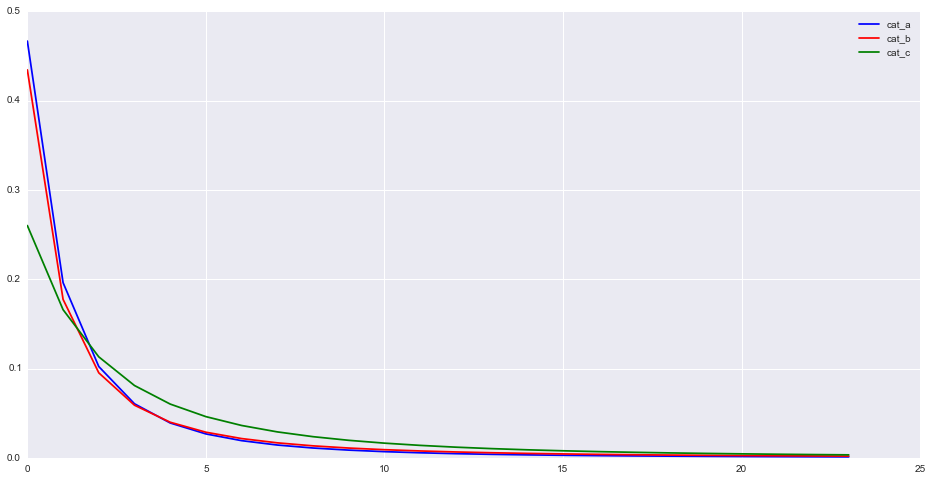

In [13]:
f, axis = plt.subplots(1, 1, figsize=(16, 8))

col_map = {'cat_a': 'b', 'cat_b': 'r', 'cat_c': 'g'}

for name, df in harz_curve.groupby('category'):
    axis.plot(df.iloc[:, 3:].mean(), alpha=1, c=col_map[name], label=name)

plt.legend()

# Visualizing the Retention Curve

In [14]:
# Predict survival curves
sc_raw = sbs.predict_survival(test, n_periods=24)

surv_curv = pd.concat([test[feature_list], 
                       sc_raw], axis=1)

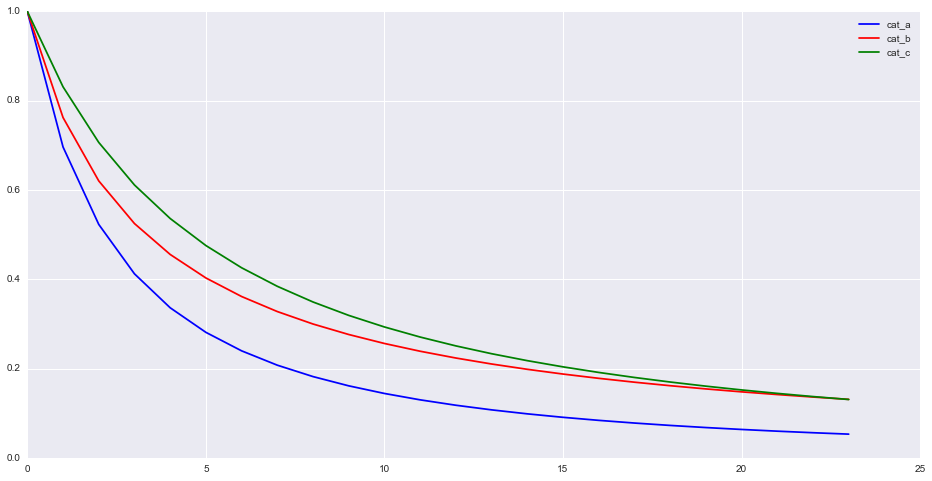

In [15]:
f, axis = plt.subplots(1, 1, figsize=(16, 8))

col_map = {'cat_a': 'b', 'cat_b': 'r', 'cat_c': 'g'}

for name, df in surv_curv.groupby('category'):
    axis.plot(df.iloc[:, 3:].mean(), alpha=1, c=col_map[name], label=name)
        


plt.legend()

# Life-Time-Value

### Initial LTV

In [16]:
ltv_initial = sbs.predict_ltv(test, age=1, alive=1, arpu=10, discount_rate=0.005)

In [17]:
test['ltvi'] = ltv_initial

### Residual LTV

In [18]:
ltv_residual = sbs.predict_ltv(test, age=None, alive=None, arpu=10, discount_rate=0.005)

In [19]:
test['ltvr'] = ltv_residual

### Relation with number of counts

In [20]:
test.groupby(['counts']).mean()

,id,numerical,alpha_true,beta_true,age,alive,ltvi,ltvr
counts,,,,,,,,
0,37507.252956,0.998732,1.547568,2.396530,3.292237,0.109306,41.684319,20.071896
1,37493.085286,0.990090,1.640323,2.060745,2.967530,0.083642,31.569602,13.594354
2,37402.820555,1.042406,1.814117,1.836548,2.650897,0.060359,22.861126,9.003823
3,36684.235294,0.963029,1.831644,1.569804,2.588235,0.058824,18.107489,8.382225
4,39531.000000,1.016733,2.363577,1.185579,1.500000,0.000000,8.411621,0.000000
5,28558.000000,0.504006,2.261821,0.992879,2.000000,0.000000,7.990128,0.000000


### Correlation with alpha and beta parameters

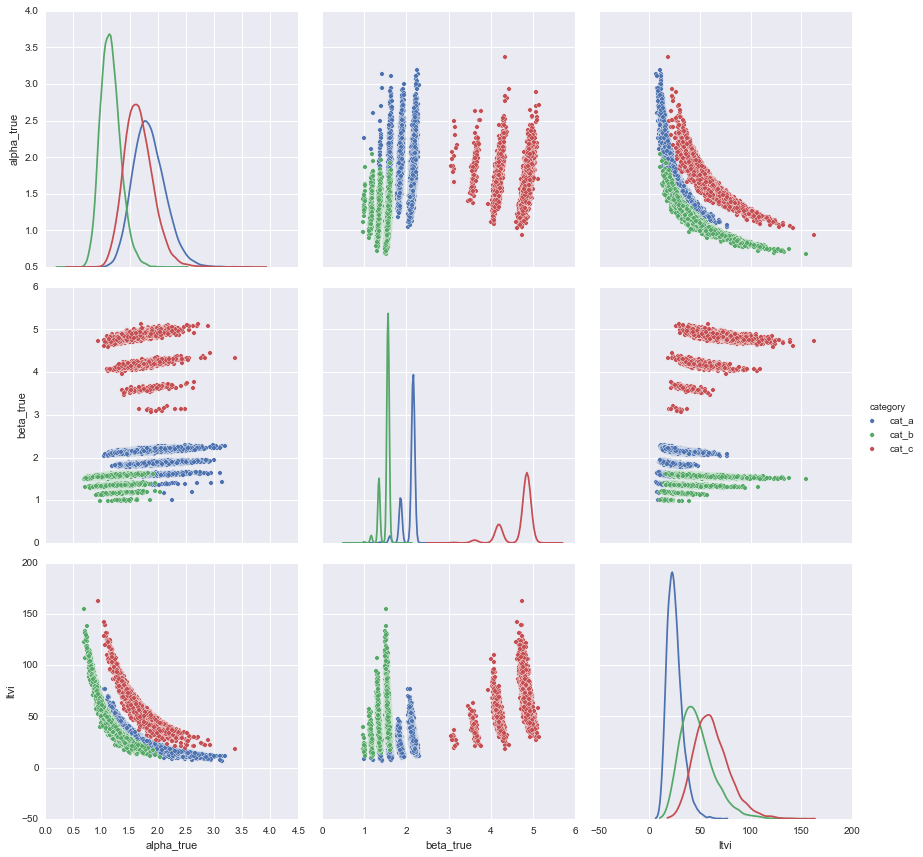

In [21]:
sns.pairplot(test, vars=['alpha_true', 'beta_true', 'ltvi'], hue='category', diag_kind='kde', size=4)